# 📥 Importing Libraries¶

In [1]:
import re
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import Callback, EarlyStopping

2021-12-31 22:52:49.234402: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-31 22:52:49.234513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 🗃️ Load Dataset


In [2]:
train_df = pd.read_csv('../input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt', sep=":::", header=None, engine='python')
test_df = pd.read_csv('../input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt', sep=":::", header=None, engine='python')
train_df.columns=['id','title','genre','description']
test_df.columns=['id','title','genre','description']
train_df.head()

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54214 non-null  int64 
 1   title        54214 non-null  object
 2   genre        54214 non-null  object
 3   description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [4]:
train_df.isnull().sum()

id             0
title          0
genre          0
description    0
dtype: int64

# 🔥 EDA & Visualization

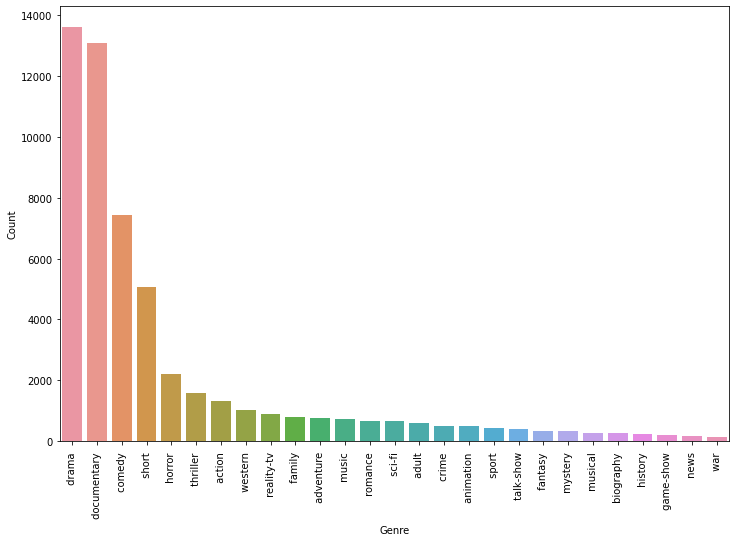

In [5]:
plt.figure(figsize=(12,8))
counts = train_df.genre.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90);

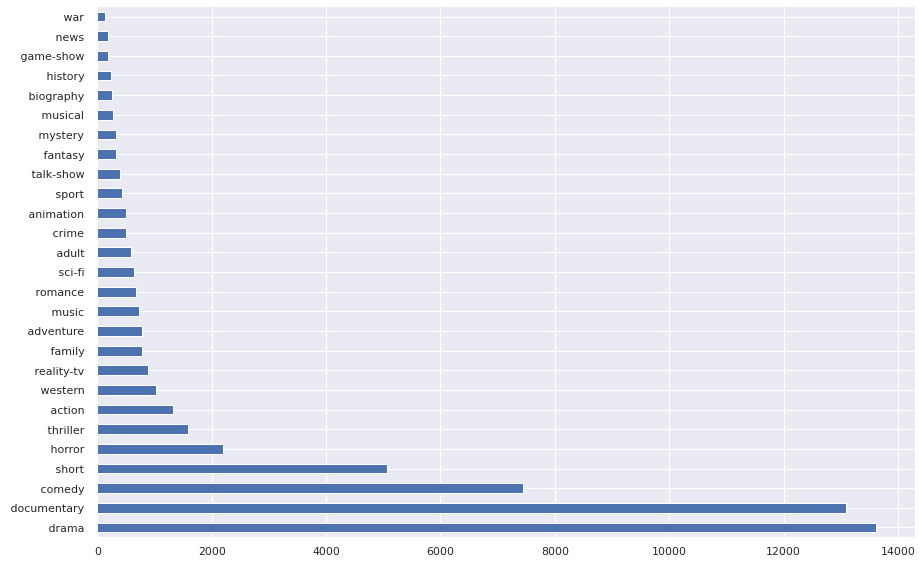

In [6]:
plt.figure(figsize=(13,8))

sns.set(style="darkgrid")
sns.set_color_codes("pastel")
train_df.genre.value_counts().plot.barh()
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [7]:
train_df.head()

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


<AxesSubplot:xlabel='count', ylabel='genre'>

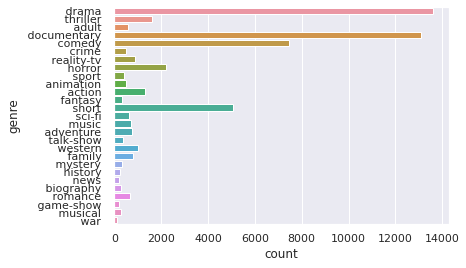

In [8]:
sns.countplot(y='genre',data=train_df)

In [9]:
train_df['length']=train_df['description'].apply(len)
train_df.head()

,id,title,genre,description,length
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


<AxesSubplot:ylabel='Frequency'>

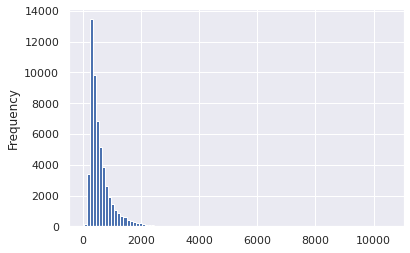

In [10]:
train_df['length'].plot(bins=100, kind='hist')

In [11]:
train_df.describe()

,id,length
count,54214.000000,54214.000000
mean,27107.500000,600.452429
std,15650.378084,446.026620
min,1.000000,42.000000
25%,13554.250000,325.000000
50%,27107.500000,464.000000
75%,40660.750000,713.000000
max,54214.000000,10504.000000


In [12]:
train_df[train_df['length']==42]['description']

52224     A buddy film set in the world of fashion.
Name: description, dtype: object

# 🧹 Text Cleaning

In [13]:
def clean_text(text):
    text = text.lower()                                  # lower-case all characters
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return text

In [14]:
train_df['Text_cleaning'] = train_df.description.apply(clean_text)
test_df['Text_cleaning'] = test_df.description.apply(clean_text)
test_df.head()

,id,title,genre,description,Text_cleaning
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...,known internationally martial arts superstar b...


In [15]:
train_df['length_Text_cleaning']=train_df['Text_cleaning'].apply(len)
train_df.head()

,id,title,genre,description,length,Text_cleaning,length_Text_cleaning
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listening conversation doctor parents year old...,383
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestuous relationship cu...,119
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empties students field trip museum natural...,402
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemployed father make ends meet edith tw...,745
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films title refers recovered bodies ground zer...,402


# ✔️ Tokenizer

In [16]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['Text_cleaning'].values)

In [17]:
X = tokenizer.texts_to_sequences(train_df['Text_cleaning'].values)
X = pad_sequences(X, maxlen=max_len)
y = pd.get_dummies(train_df['genre']).values

X_test = tokenizer.texts_to_sequences(test_df['Text_cleaning'].values)
X_test = pad_sequences(X_test, maxlen=max_len)
y_test = pd.get_dummies(test_df['genre']).values

# 📚 Training model

In [18]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2021-12-31 22:55:56.106295: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-31 22:55:56.109679: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-31 22:55:56.109713: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-31 22:55:56.109742: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e110b466aad5): /proc/driver/nvidia/version does not exist
2021-12-31 22:55:56.110855: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [19]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [20]:
history = model.fit(X, y, epochs=6, batch_size=32,validation_data=(X_test,y_test), callbacks=my_callbacks)

2021-12-31 22:55:56.681592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-31 22:55:56.694509: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/6
1695/1695 [==============================] - 671s 394ms/step - loss: 2.1855 - accuracy: 0.3622 - val_loss: 1.6585 - val_accuracy: 0.5152
Epoch 2/6
1695/1695 [==============================] - 684s 403ms/step - loss: 1.4378 - accuracy: 0.5856 - val_loss: 1.5123 - val_accuracy: 0.5620
Epoch 3/6
1695/1695 [==============================] - 682s 402ms/step - loss: 1.0284 - accuracy: 0.7021 - val_loss: 1.5775 - val_accuracy: 0.5549
Epoch 4/6
1695/1695 [==============================] - 691s 408ms/step - loss: 0.7454 - accuracy: 0.7847 - val_loss: 1.7323 - val_accuracy: 0.5542


# 📈 Plotting Accuracy & Loss


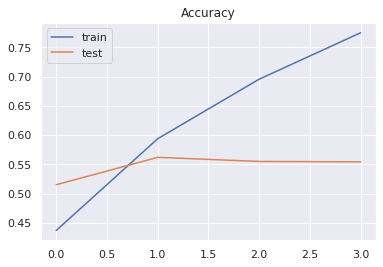

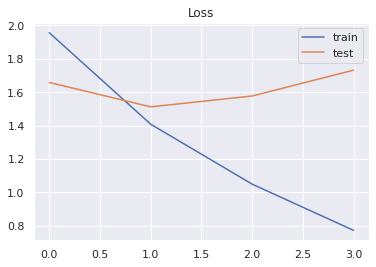

In [21]:
# Plotting Accuracy and val_accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Plotting loss and val_loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

# 🧪 Test Accuracy

In [22]:
results = model.evaluate(X_test, y_test, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.73233
Test Accuracy: 55.42%
